# DX 704 Week 1 Project

This week's project will build a portfolio risk and return model, and make investing recommendations for hypothetical clients.
You will collect historical data, estimate returns and risks, construct efficient frontier portfolios, and sanity check the certainty of the maximum return portfolio.

The full project description and a template notebook are available on GitHub at the following link.

https://github.com/bu-cds-dx704/dx704-project-01


Feel free to use optimization tools or libraries (such as CVXOPT or scipy.optimize) to perform any calculations required for this mini project.

### Example Code

You may find it helpful to refer to these GitHub repositories of Jupyter notebooks for example code.

* https://github.com/bu-cds-omds/dx601-examples
* https://github.com/bu-cds-omds/dx602-examples
* https://github.com/bu-cds-omds/dx603-examples
* https://github.com/bu-cds-omds/dx704-examples

Any calculations demonstrated in code examples or videos may be found in these notebooks, and you are allowed to copy this example code in your homework answers.

## Part 1: Collect Data

Collect historical monthly price data for the last 24 months covering 6 different stocks.
The data should cover 24 consecutive months including the last month that ended before this week's material was released on Blackboard.
To be clear, if a month ends between the Blackboard release and submitting your project, you do not need to add that month.

The six different stocks must include AAPL, SPY and TSLA.
At least one of the remaining 3 tickers must start with the same letter as your last name (e.g. professor Considine could use COIN).
This is to encourage diversity in what stocks you analyze; if you discuss this project with classmates, please make sure that you pick different tickers to differentiate your work.
Do not pick stocks with fewer than 24 consecutive months of price data.

In [142]:
# Load libraries
import pandas as pd
import yfinance as yf
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

# Turn off scientific notation for pandas and numpy
pd.options.display.float_format = "{:.6f}".format
np.set_printoptions(suppress=True, formatter={"float_kind": "{:.6f}".format})

In [143]:
# YOUR CHANGES HERE
# Specify stocks
tickers = ["AAPL", "SPY", "TSLA", "PEP", "PYPL", "PARA"]

# Specify monthd
start_month = "2023-09-01"  
end_month_exclusive = "2025-09-01" 
target_months = pd.period_range("2023-09", "2025-08", freq="M")  


In [144]:
# Let's dowload daily data 
raw = yf.download(
    tickers=tickers,
    start=start_month,
    end=end_month_exclusive,
    auto_adjust=False,            
    progress=False,
    group_by="column",           
)

In [145]:
# Take a look
raw.head()

Price       Adj Close                                                       \
Ticker           AAPL      PARA        PEP      PYPL        SPY       TSLA   
Date                                                                         
2023-09-01 187.622253 13.195582 163.701599 63.570000 439.492126 245.009995   
2023-09-05 187.859924 13.195582 162.618500 63.740002 437.592682 256.489990   
2023-09-06 181.135803 12.953907 163.150711 62.799999 434.651001 251.919998   
2023-09-07 175.837692 12.586558 164.710052 61.650002 433.316528 251.490005   
2023-09-08 176.451645 13.205253 164.588654 60.980000 433.969116 248.500000   

Price           Close                                 ...       Open  \
Ticker           AAPL      PARA        PEP      PYPL  ...        PEP   
Date                                                  ...              
2023-09-01 189.460007 13.650000 175.320007 63.570000  ... 178.729996   
2023-09-05 189.699997 13.650000 174.160004 63.740002  ... 175.270004   
2023-09-06 182.910004 13.400000 174.729996 62.799999  ... 174.919998   
2023-09-07 177.559998 13.020000 176.399994 61.650002  ... 175.850006   
2023-09-08 178.179993 13.660000 176.270004 60.980000  ... 175.809998   

Price                                          Volume                     \
Ticker          PYPL        SPY       TSLA       AAPL      PARA      PEP   
Date                                                                       
2023-09-01 63.130001 453.170013 257.260010   45766500  32745292  4801400   
2023-09-05 63.380001 450.730011 245.000000   45280000  12582628  5081800   
2023-09-06 63.119999 448.399994 255.139999   81755800  15497299  5933800   
2023-09-07 62.000000 443.109985 245.070007  112488800  20686648  4934300   
2023-09-08 61.580002 444.899994 251.220001   65551300  13785068  2995000   

Price                                      
Ticker          PYPL       SPY       TSLA  
Date                                       
2023-09-01  11715200  58944100  132541600  
2023-09-05  12739100  55166200  129469600  
2023-09-06  13621300  70758500  116959800  
2023-09-07  12712700  70355400  115312900  
2023-09-08  15367400  61659700  118367700  

[5 rows x 36 columns]

In [146]:
raw.shape

(500, 36)

In [147]:
# Take only the adjusted price 
adj_close = raw["Adj Close"]


In [148]:
adj_close.head()

Ticker,AAPL,PARA,PEP,PYPL,SPY,TSLA
Date,,,,,,
2023-09-01,187.622253,13.195582,163.701599,63.570000,439.492126,245.009995
2023-09-05,187.859924,13.195582,162.618500,63.740002,437.592682,256.489990
2023-09-06,181.135803,12.953907,163.150711,62.799999,434.651001,251.919998
2023-09-07,175.837692,12.586558,164.710052,61.650002,433.316528,251.490005
2023-09-08,176.451645,13.205253,164.588654,60.980000,433.969116,248.500000


In [149]:
adj_close.shape

(500, 6)

In [150]:
# Resample to month-end prices (last trading day each month)
monthly_prices = adj_close.resample("ME").last()

In [151]:
monthly_prices.head()

Ticker,AAPL,PARA,PEP,PYPL,SPY,TSLA
Date,,,,,,
2023-09-30,169.549286,12.517363,158.211288,58.459999,417.865631,250.220001
2023-10-31,169.113571,10.557281,152.459503,51.799999,408.794373,200.839996
2023-11-30,188.355316,13.943759,158.335693,57.610001,446.135223,240.080002
2023-12-31,190.913651,14.397066,159.794022,61.410000,466.503693,248.479996
2024-01-31,182.851898,14.202379,158.561523,61.349998,473.933411,187.289993


In [152]:
monthly_prices.shape

(24, 6)

In [153]:
# Check if all have 24 months of data
print(monthly_prices.isna().any())

Ticker
AAPL    False
PARA    False
PEP     False
PYPL    False
SPY     False
TSLA    False
dtype: bool


In [154]:
monthly_prices.head()

Ticker,AAPL,PARA,PEP,PYPL,SPY,TSLA
Date,,,,,,
2023-09-30,169.549286,12.517363,158.211288,58.459999,417.865631,250.220001
2023-10-31,169.113571,10.557281,152.459503,51.799999,408.794373,200.839996
2023-11-30,188.355316,13.943759,158.335693,57.610001,446.135223,240.080002
2023-12-31,190.913651,14.397066,159.794022,61.410000,466.503693,248.479996
2024-01-31,182.851898,14.202379,158.561523,61.349998,473.933411,187.289993


Save the data as a TSV file named "historical_prices.tsv" and include a header row with the column names "date" and the 6 stock ticker symbols.
The date should be the last trading day of the month, so it may not be the last day of the month.
For example, the last trading day of November 2024 was 2024-11-29.
The remaining columns should contain the adjusted closing prices of the corresponding stock tickers on that day.


In [155]:
# YOUR CHANGES HERE

# Fix index
# Reset index so date is a column
monthly_prices = monthly_prices.reset_index()
monthly_prices.rename(columns={"Date": "date"}, inplace=True)

# Remove the column index name ("Ticker")
monthly_prices.columns.name = None

# Save to TSV, keeping 'date' as a regular column
monthly_prices.to_csv("historical_prices.tsv", sep="\t", index=False, float_format="%.6f")


In [156]:
monthly_prices.head()

,date,AAPL,PARA,PEP,PYPL,SPY,TSLA
0,2023-09-30,169.549286,12.517363,158.211288,58.459999,417.865631,250.220001
1,2023-10-31,169.113571,10.557281,152.459503,51.799999,408.794373,200.839996
2,2023-11-30,188.355316,13.943759,158.335693,57.610001,446.135223,240.080002
3,2023-12-31,190.913651,14.397066,159.794022,61.410000,466.503693,248.479996
4,2024-01-31,182.851898,14.202379,158.561523,61.349998,473.933411,187.289993


Submit "historical_prices.tsv" in Gradescope.

## Part 2: Calculate Historical Asset Returns

Calculate the historical asset returns based on the price data that you previously collected.

In [157]:
historical_prices = None

for t in tickers:
    ticker = yf.Ticker(t)
    history =  ticker.history(period="2y")

    monthly_prices = history['Close'].resample('ME').last()

    if historical_prices is None:
        historical_prices = monthly_prices
    else:
        historical_prices = pd.concat([historical_prices, monthly_prices], axis=1)

historical_prices.columns = tickers
historical_prices.index = pd.to_datetime(historical_prices.index).strftime("%Y-%m")

historical_prices

,AAPL,SPY,TSLA,PEP,PYPL,PARA
Date,,,,,,
2023-09,169.549271,417.865692,250.220001,158.211288,58.459999,12.517362
2023-10,169.113556,408.794312,200.839996,152.459488,51.799999,10.557280
2023-11,188.355316,446.135193,240.080002,158.335724,57.610001,13.943759
2023-12,190.913651,466.503693,248.479996,159.794006,61.410000,14.397064
2024-01,182.851913,473.933411,187.289993,158.561523,61.349998,14.202380
2024-02,179.461273,498.666473,201.880005,156.747314,60.340000,10.746695
2024-03,170.257339,514.973877,175.789993,165.914780,66.989998,11.506557
2024-04,169.115570,494.210327,183.279999,166.768021,67.919998,11.135063
2024-05,191.138168,519.207336,178.080002,163.914413,62.990002,11.643424


In [158]:
# Save to TSV, keeping 'date' as a regular column
historical_prices.to_csv("historical_prices.tsv", sep="\t", index=False, float_format="%.6f")


In [159]:
historical_prices = historical_prices.reset_index()
historical_prices.rename(columns={"Date": "date"}, inplace=True)

# Remove the column index name ("Ticker")
historical_prices.columns.name = None

# Save to TSV, keeping 'date' as a regular column
historical_prices.to_csv("historical_prices.tsv", sep="\t", index=False, float_format="%.6f")


In [160]:
historical_prices.head()

,date,AAPL,SPY,TSLA,PEP,PYPL,PARA
0,2023-09,169.549271,417.865692,250.220001,158.211288,58.459999,12.517362
1,2023-10,169.113556,408.794312,200.839996,152.459488,51.799999,10.557280
2,2023-11,188.355316,446.135193,240.080002,158.335724,57.610001,13.943759
3,2023-12,190.913651,466.503693,248.479996,159.794006,61.410000,14.397064
4,2024-01,182.851913,473.933411,187.289993,158.561523,61.349998,14.202380


In [161]:
historical_prices = historical_prices.sort_values("date")
historical_prices = historical_prices.iloc[1:].copy()
historical_prices.to_csv("historical_prices.tsv", sep="\t", index=False, float_format="%.6f")

In [162]:
historical_prices

,date,AAPL,SPY,TSLA,PEP,PYPL,PARA
1,2023-10,169.113556,408.794312,200.839996,152.459488,51.799999,10.557280
2,2023-11,188.355316,446.135193,240.080002,158.335724,57.610001,13.943759
3,2023-12,190.913651,466.503693,248.479996,159.794006,61.410000,14.397064
4,2024-01,182.851913,473.933411,187.289993,158.561523,61.349998,14.202380
5,2024-02,179.461273,498.666473,201.880005,156.747314,60.340000,10.746695
6,2024-03,170.257339,514.973877,175.789993,165.914780,66.989998,11.506557
7,2024-04,169.115570,494.210327,183.279999,166.768021,67.919998,11.135063
8,2024-05,191.138168,519.207336,178.080002,163.914413,62.990002,11.643424
9,2024-06,209.401901,537.525024,197.880005,157.591522,58.029999,10.207629
10,2024-07,220.795654,544.033936,232.070007,164.987122,65.779999,11.219551


In [163]:
historical_prices.shape

(24, 7)

In [164]:
# YOUR CHANGES HERE

historical_prices["date"] = pd.to_datetime(historical_prices["date"])

# Use date as index for the computation only
prices_idx = historical_prices.set_index("date")

# Compute monthly *relative* returns, then bring date back as a column
historical_returns = prices_idx.pct_change().dropna()
historical_returns = historical_returns.reset_index()  # 'date' becomes a column again

# Save (23 rows expected)
historical_returns.to_csv("historical_returns.tsv", sep="\t", index=False, float_format="%.6f")

# Compute mean returns per asset (ignore the 'date' column)
estimated_returns = historical_returns.drop(columns=["date"]).mean().rename("return")

# (Optional) If you want a 2-col TSV: asset + estimated_return
estimated_returns.reset_index().rename(columns={"index":"asset","return":"estimated_return"}) \
                 .to_csv("estimated_returns.tsv", sep="\t", index=False, float_format="%.6f")

In [165]:
estimated_returns

AAPL    0.016968
SPY     0.020758
TSLA    0.036103
PEP    -0.001045
PYPL    0.015230
PARA    0.020493
Name: return, dtype: float64

Save the data as a TSV file named "historical_returns.tsv" and include a header row with the column names "date" and the 6 stock ticker symbols.
Each row should have the date at the end of the month and the corresponding *relative* price changes.
For example, if the previous price was \$100 and the new price is \$110, the return value should be 0.10.
There should only be 23 rows of data in this file, since they are computed as the differences of 24 prices.

In [166]:
# YOUR CHANGES HERE

# Reset index so date becomes a column
historical_returns = historical_returns.reset_index()

#Save as TSV with header row (date + tickers)
historical_returns.to_csv("historical_returns.tsv", sep="\t", index=False)

In [167]:
historical_returns.head()

,index,date,AAPL,SPY,TSLA,PEP,PYPL,PARA
0,0,2023-11-01,0.113780,0.091344,0.195379,0.038543,0.112162,0.320772
1,1,2023-12-01,0.013582,0.045655,0.034988,0.009210,0.065961,0.032510
2,2,2024-01-01,-0.042227,0.015926,-0.246257,-0.007713,-0.000977,-0.013522
3,3,2024-02-01,-0.018543,0.052187,0.077901,-0.011442,-0.016463,-0.243317
4,4,2024-03-01,-0.051286,0.032702,-0.129235,0.058486,0.110209,0.070707


In [168]:
historical_returns.shape

(23, 8)

Submit "historical_returns.tsv" in Gradescope.

## Part 3: Estimate Returns

Estimate the expected returns for each asset using the previously calculated return data.
Just compute the average (mean) return for each asset over your data set; do not use other estimators that have been mentioned.
This will serve as your estimate of expected return for each asset.

In [169]:
# YOUR CHANGES HERE
# We calculated estimated returns before to not have datetime column
print(estimated_returns)

AAPL    0.016968
SPY     0.020758
TSLA    0.036103
PEP    -0.001045
PYPL    0.015230
PARA    0.020493
Name: return, dtype: float64


In [170]:
estimated_returns.shape

(6,)

Save the estimated returns in a TSV file named "estimated_returns.tsv" and include a header row with the column names "asset" and "estimated_return".

In [171]:
# YOUR CHANGES HERE

# estimated_returns = estimated_returns.reset_index()
# estimated_returns.rename(columns={"index": "asset"}, inplace=True)

# # Save to TSV
# estimated_returns.to_csv("estimated_returns.tsv", sep="\t", index=False)

In [172]:
estimated_returns.head(10)

AAPL    0.016968
SPY     0.020758
TSLA    0.036103
PEP    -0.001045
PYPL    0.015230
PARA    0.020493
Name: return, dtype: float64

Submit "estimated_returns.tsv" in Gradescope.

## Part 4: Estimate Risk

Estimate the covariance matrix for the asset returns to understand how the assets move together.

In [173]:
# YOUR CHANGES HERE
# Covariance matrix:
returns_only = historical_returns.drop(columns=["date"], errors="ignore")

estimated_covariance = returns_only.cov()
estimated_variances = returns_only.var()

In [174]:
estimated_variances

index   46.000000
AAPL     0.003623
SPY      0.001225
TSLA     0.024358
PEP      0.001495
PYPL     0.006413
PARA     0.010864
dtype: float64

In [175]:
estimated_covariance

,index,AAPL,SPY,TSLA,PEP,PYPL,PARA
index,46.000000,-0.038953,-0.067988,0.022150,-0.018207,-0.155286,0.040835
AAPL,-0.038953,0.003623,0.000784,0.003075,0.000607,-0.000091,0.001827
SPY,-0.067988,0.000784,0.001225,0.001971,0.000318,0.001226,0.000696
TSLA,0.022150,0.003075,0.001971,0.024358,-0.001190,0.006047,0.000919
PEP,-0.018207,0.000607,0.000318,-0.001190,0.001495,0.000669,0.001965
PYPL,-0.155286,-0.000091,0.001226,0.006047,0.000669,0.006413,0.002463
PARA,0.040835,0.001827,0.000696,0.000919,0.001965,0.002463,0.010864


Save the estimated covariances to a TSV file named "estimated_covariance.tsv".
The header row should have a blank column name followed by the names of the assets.
Each data row should start with the name of an asset for that row, and be followed by the individual covariances corresponding to that row and column's assets.
(This is the format of pandas's `to_csv` method with `sep="\t"` when used on a covariance matrix as computed in the examples.)

In [176]:
# YOUR CHANGES HERE

estimated_covariance.to_csv("estimated_covariance.tsv", sep="\t")

Submit "estimated_covariance.tsv" in Gradescope.

## Part 5: Construct the Maximum Return Portfolio

Compute the maximum return portfolio based on your previously estimated risks and returns.

In [177]:
# Standardize estimated_returns to a Series with ticker index
if isinstance(estimated_returns, pd.DataFrame):
    # Case: two-column DataFrame
    if {"asset", "return"}.issubset(estimated_returns.columns):
        estimated_returns = (
            estimated_returns.set_index("asset")["return"].astype(float)
        )
    else:
        # Case: single-column DataFrame
        estimated_returns = estimated_returns.squeeze("columns").astype(float)
else:
    # Already a Series
    estimated_returns = estimated_returns.astype(float)

# Align covariance 
estimated_covariance = (
    estimated_covariance
    .reindex(index=estimated_returns.index, columns=estimated_returns.index)
    .astype(float)
)


mu = estimated_returns.values.astype(float)      # shape (n,)
Sigma = estimated_covariance.values.astype(float)  # shape (n,n)
n = len(mu)

# Max-return portfolio 
x_max = cp.Variable(n)
prob_max = cp.Problem(cp.Maximize(mu @ x_max),
                      [x_max >= 0,
                       cp.sum(x_max) == 1])
_ = prob_max.solve()

w_max = np.array(x_max.value, dtype=float)
ret_max = float(mu @ w_max)
var_max = float(w_max @ Sigma @ w_max)
std_max = float(np.sqrt(var_max))


print("Maximum-return portfolio (weights):")
for asset, w in zip(estimated_returns.index.tolist(), w_max):
    print(f"  {asset}: {w:.4f}")
print(f"\nExpected monthly return: {ret_max:.6f}")
print(f"Monthly variance:        {var_max:.6f}")
print(f"Monthly std. dev.:       {std_max:.6f}")

Maximum-return portfolio (weights):
  AAPL: 0.0000
  SPY: 0.0000
  TSLA: 1.0000
  PEP: 0.0000
  PYPL: 0.0000
  PARA: 0.0000

Expected monthly return: 0.036103
Monthly variance:        0.024358
Monthly std. dev.:       0.156070


Save the maximum return portfolio in a TSV file named "maximum_return.tsv".
The header row should have two columns, "asset" and "allocation".
The allocation values should sum up to one.


In [178]:
# YOUR CHANGES HERE

# Build a DataFrame with asset and allocation
max_return_portfolio = (
    pd.Series(w_max, index=estimated_returns.index, name="allocation")
    .rename_axis("asset")
    .reset_index()
)

# Save to TSV
max_return_portfolio.to_csv("maximum_return.tsv", sep="\t", index=False)



In [179]:
max_return_portfolio

,asset,allocation
0,AAPL,0.000000
1,SPY,0.000000
2,TSLA,1.000000
3,PEP,0.000000
4,PYPL,0.000000
5,PARA,0.000000


Submit "maximum_return.tsv" in Gradescope.

## Part 6: Construct the Minimum Risk Portfolio

Compute the minimum risk portfolio based on your previously estimated risks.

In [180]:
# YOUR CHANGES HERE

# estimated_covariance
assets = estimated_covariance.index.tolist()
Sigma = (
    estimated_covariance
    .reindex(index=assets, columns=assets)   # just to be explicit
    .astype(float)
    .values
)


if isinstance(estimated_returns, pd.DataFrame):
    # handle the case where it's a 2-col DF (asset, return)
    if {"asset", "return"}.issubset(estimated_returns.columns):
        mu_s = estimated_returns.set_index("asset")["return"].astype(float).reindex(assets)
    else:
        mu_s = estimated_returns.squeeze("columns").astype(float).reindex(assets)
else:
    mu_s = pd.Series(estimated_returns, index=getattr(estimated_returns, "index", assets), dtype=float).reindex(assets)

mu = mu_s.values.astype(float)  


n = len(assets)
x_min = cp.Variable(n)
prob_min = cp.Problem(
    cp.Minimize(cp.quad_form(x_min, Sigma)),
    [x_min >= 0, cp.sum(x_min) == 1]
)
var_min = prob_min.solve()

w_min = np.array(x_min.value, dtype=float)
std_min = float(np.sqrt(var_min))
ret_min = float(mu @ w_min)  


print("Minimum-risk (GMV) portfolio weights:")
for a, w in zip(assets, w_min):
    print(f"  {a}: {w:.6f}")
print(f"\nGMV variance:  {var_min:.6f}")
print(f"GMV st. dev.:  {std_min:.6f}")
print(f"GMV exp. ret.: {ret_min:.6f}") 

Minimum-risk (GMV) portfolio weights:
  AAPL: 0.034565
  SPY: 0.525519
  TSLA: 0.008052
  PEP: 0.431864
  PYPL: -0.000000
  PARA: 0.000000

GMV variance:  0.000824
GMV st. dev.:  0.028710
GMV exp. ret.: 0.011335


Save the minimum risk portfolio in a TSV file named "minimum_risk.tsv".
The header row should have two columns, "asset" and "allocation".
The allocation values should sum up to one.


In [181]:
# YOUR CHANGES HERE

min_risk_df = pd.DataFrame({
    "asset": assets,          
    "allocation": w_min       
})

# Allocations sum to 1
assert abs(min_risk_df["allocation"].sum() - 1.0) < 1e-8, "Weights do not sum to 1!"

# Save to TSV
min_risk_df.to_csv("minimum_risk.tsv", sep="\t", index=False, float_format="%.6f")

In [182]:
min_risk_df

,asset,allocation
0,AAPL,0.034565
1,SPY,0.525519
2,TSLA,0.008052
3,PEP,0.431864
4,PYPL,-0.000000
5,PARA,0.000000


Submit "minimum_risk.tsv" in Gradescope.

## Part 7: Build Efficient Frontier Portfolios

Compute 101 portfolios along the mean-variance efficient frontier with evenly spaced estimated returns.
The first portfolio should be the minimum risk portfolio from part 4, and the last portfolio should be the maximum return portfolio from part 3.
The estimated return of each portfolio should be higher than the previous by one percent of the difference between the first and last portfolios.
That is, the estimated return of the portfolios should be similar to `np.linspace(min_risk_return, max_return, 101)`.


In [183]:
# YOUR CHANGES HERE

if isinstance(estimated_returns, pd.DataFrame):
    if {"asset", "return"}.issubset(estimated_returns.columns):
        mu_s = estimated_returns.set_index("asset")["return"].astype(float)
    else:
        mu_s = estimated_returns.squeeze("columns").astype(float)
else:
    mu_s = pd.Series(estimated_returns, dtype=float)

assets = mu_s.index.tolist()
mu = mu_s.values.astype(float)  # shape (n,)

# Align covariance to the same order of tickers
Sigma = (
    estimated_covariance
    .reindex(index=assets, columns=assets)
    .astype(float)
    .values
)
n = len(assets)

# Minimum-risk portfolio
x_min = cp.Variable(n)
prob_min = cp.Problem(cp.Minimize(cp.quad_form(x_min, Sigma)),
                      [x_min >= 0, cp.sum(x_min) == 1])
var_min = prob_min.solve()
w_min = np.array(x_min.value, dtype=float)
ret_min = float(mu @ w_min)

# Maximum-return portfolio 
x_max = cp.Variable(n)
prob_max = cp.Problem(cp.Maximize(mu @ x_max),
                      [x_max >= 0, cp.sum(x_max) == 1])
_ = prob_max.solve()
w_max = np.array(x_max.value, dtype=float)
ret_max = float(mu @ w_max)

# 101 evenly spaced target returns 
r_grid = np.linspace(ret_min, ret_max, 101)

ef_returns = []
ef_variances = []
ef_portfolios = []


last_x = w_min  
for r in r_grid:
    x = cp.Variable(n)
    constraints = [x >= 0, cp.sum(x) == 1, mu @ x == r]
    obj = cp.Minimize(cp.quad_form(x, Sigma))
    prob = cp.Problem(obj, constraints)
    try:
        _ = prob.solve(solver=cp.ECOS, warm_start=True)
    except Exception:
        _ = prob.solve(solver=cp.SCS, warm_start=True, verbose=False)

    w = np.array(x.value, dtype=float)
    # Fallback in rare numerical cases
    if w is None or not np.isfinite(w).all():
        w = last_x.copy()
    last_x = w

    ef_portfolios.append(w)
    ef_returns.append(float(r))
    ef_variances.append(float(w @ Sigma @ w))

ef_portfolios = np.vstack(ef_portfolios)  # shape (101, n)
ef_returns = np.array(ef_returns)
ef_variances = np.array(ef_variances)

print("EF computed: 101 portfolios,",
      "returns from", ef_returns[0], "to", ef_returns[-1],
      "std range:", np.sqrt(ef_variances).min(), "→", np.sqrt(ef_variances).max())

EF computed: 101 portfolios, returns from 0.01133479062463983 to 0.03610310033615892 std range: 0.028710541465757137 → 0.1560704334940731


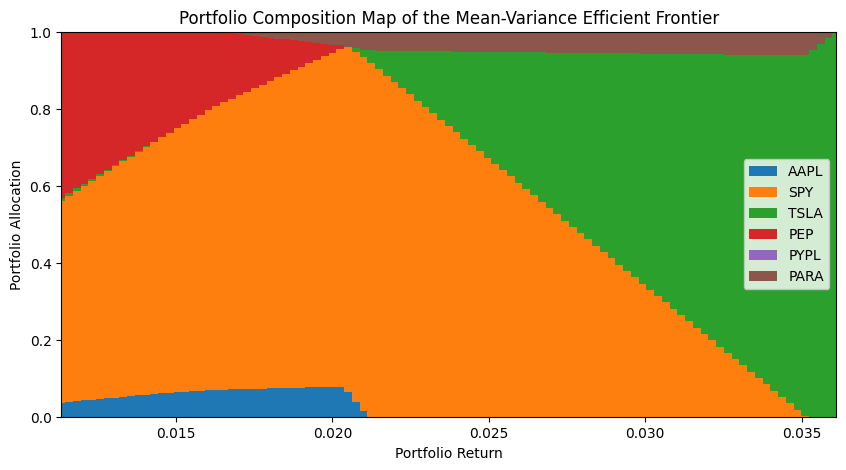

In [184]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
bottom = np.zeros(ef_portfolios.shape[0])

# Ensure the plotting order matches the portfolio columns
for i, a in enumerate(assets):
    plt.bar(x=ef_returns,
            height=ef_portfolios[:, i],
            bottom=bottom,
            label=a,
            width=(ef_returns[1] - ef_returns[0]))
    bottom += ef_portfolios[:, i]

plt.legend()
plt.xlabel("Portfolio Return")
plt.xlim(float(ef_returns.min()), float(ef_returns.max()))
plt.ylabel("Portfolio Allocation")
plt.ylim(0, 1)
plt.title("Portfolio Composition Map of the Mean-Variance Efficient Frontier")
plt.show()

Save the portfolios in a TSV file named "efficient_frontier.tsv".
The header row should have columns "index", "return", "risk", and all the asset tickers.
Each data row should have the portfolio index (0-100), the estimated return of the portfolio, the estimated standard deviation (not variance) of the portfolio, and all the asset allocations (which should sum to one).

In [185]:
# YOUR CHANGES HERE

ef_risks = np.sqrt(ef_variances)

# Build DataFrame
ef_df = pd.DataFrame(ef_portfolios, columns=assets)
ef_df.insert(0, "risk", ef_risks)
ef_df.insert(0, "return", ef_returns)
ef_df.insert(0, "index", np.arange(len(ef_returns)))

# Allocations sum to 1 
assert np.allclose(ef_df[assets].sum(axis=1), 1.0, atol=1e-6)

# Save to TSV
ef_df.to_csv("efficient_frontier.tsv", sep="\t", index=False, float_format="%.6f")

Submit "efficient_frontier.tsv" in Gradescope.

## Part 8: Check Maximum Return Portfolio Stability

Check the stability of the maximum return portfolio by resampling the estimated risk/return model.

Repeat 1000 times -
1. Use `np.random.multivariate_normal` to generate 23 return samples using your previously estimated risks and returns.
2. Estimate the return of each asset using that resampled return history.
3. Check which asset had the highest return in those resampled estimates.

This procedure is a reduced and simplified version of the Michaud resampled efficient frontier procedure that takes uncertainty in the risk model into account.

In [186]:
# YOUR CHANGES HERE

# Standardize inputs 
if isinstance(estimated_returns, pd.DataFrame):
    mu_s = estimated_returns.set_index("asset")["return"].astype(float)
else:
    mu_s = pd.Series(estimated_returns, dtype=float)
assets = mu_s.index.tolist()
mu = mu_s.values.astype(float)

Sigma = (
    estimated_covariance
    .reindex(index=assets, columns=assets)
    .astype(float)
).values

Sigma = (Sigma + Sigma.T) / 2.0
eigvals = np.linalg.eigvalsh(Sigma)
min_eig = eigvals.min()
if min_eig < 1e-12:
    # add a small ridge to make it PSD
    Sigma += np.eye(Sigma.shape[0]) * (1e-8 - min_eig)

# Resample
B = 1000       # number of resamples
T = 23         # length of return history to simulate (differences of 24 prices)
rng = np.random.default_rng(704)

winner_counts = np.zeros(len(assets), dtype=int)

for _ in range(B):
    # simulate T monthly returns from MVN(mu, Sigma)
    sim = rng.multivariate_normal(mean=mu, cov=Sigma, size=T)  # shape (T, n_assets)
    sim_means = sim.mean(axis=0)                                # mean return per asset
    winner = int(np.argmax(sim_means))                          # index of top-mean asset
    winner_counts[winner] += 1

winner_share = winner_counts / B

stability_df = pd.DataFrame({
    "asset": assets,
    "wins": winner_counts,
    "share": winner_share
}).sort_values("share", ascending=False).reset_index(drop=True)

print(stability_df)

orig_best = mu_s.idxmax()
orig_best_share = float(stability_df.loc[stability_df["asset"] == orig_best, "share"])
print(f"\nOriginal max-return asset: {orig_best} — wins in {orig_best_share:.3f} of resamples.")


  asset  wins    share
0  TSLA   551 0.551000
1  PARA   221 0.221000
2   SPY   106 0.106000
3  AAPL    75 0.075000
4  PYPL    47 0.047000
5   PEP     0 0.000000

Original max-return asset: TSLA — wins in 0.551 of resamples.


/tmp/ipykernel_32273/1401760613.py:49: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  orig_best_share = float(stability_df.loc[stability_df["asset"] == orig_best, "share"])


Save a file "max_return_probabilities.tsv" with the distribution of highest return assets.
The header row should have columns "asset" and "probability".
There should be a data row for each asset and its sample probability of having the highest return based on those 1000 resampled estimates.


In [187]:
# YOUR CHANGES HERE

B = 1000  # number of resamples used

# Build probability DataFrame
prob_df = pd.DataFrame({
    "asset": assets,
    "probability": winner_counts / B
})

# Save to TSV 
prob_df.to_csv("max_return_probabilities.tsv", sep="\t", index=False, float_format="%.6f")

In [188]:
prob_df.head()

,asset,probability
0,AAPL,0.075000
1,SPY,0.106000
2,TSLA,0.551000
3,PEP,0.000000
4,PYPL,0.047000


In [189]:
prob_df.shape

(6, 2)

Submit "max_return_probabilities.tsv" in Gradescope.

## Part 9: Acknowledgments

Make a file "acknowledgments.txt" documenting any outside sources or help on this project.
If you discussed this assignment with anyone, please acknowledge them here.
If you used any libraries not mentioned in this module's content, please list them with a brief explanation what you used them for.
If you used any generative AI tools, please add links to your transcripts below, and any other information that you feel is necessary to comply with the generative AI policy.
If no acknowledgements are appropriate, just write none in the file.


In [190]:
from pathlib import Path

# Create acknowledgements.txt in the current working directory
Path("acknowledgements.txt").write_text("I only used Week 1 lecture code.\n", encoding="utf-8")

# Sanity check
p = Path("acknowledgements.txt").resolve()
print("Wrote:", p)
print("Exists:", p.exists())

Wrote: /workspaces/dx704-project-01/acknowledgements.txt
Exists: True


Submit "acknowledgements.txt" in Gradescope.

## Part 10: Code

Please submit a Jupyter notebook that can reproduce all your calculations and recreate the previously submitted files.
You do not need to provide code for data collection if you did that by manually.

Submit "project.ipynb" in Gradescope.